In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [12]:
df = pd.read_csv("dataset/hourly_radiation_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    52584 non-null  object 
 1   P       52584 non-null  float64
 2   Gb(i)   52584 non-null  float64
 3   Gd(i)   52584 non-null  float64
 4   Gr(i)   52584 non-null  float64
 5   H_sun   52584 non-null  float64
 6   T2m     52584 non-null  float64
 7   WS10m   52584 non-null  float64
 8   Int     52584 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [13]:
df = df.drop(columns='Int')
p_col = df.pop('P')
df['P'] = p_col

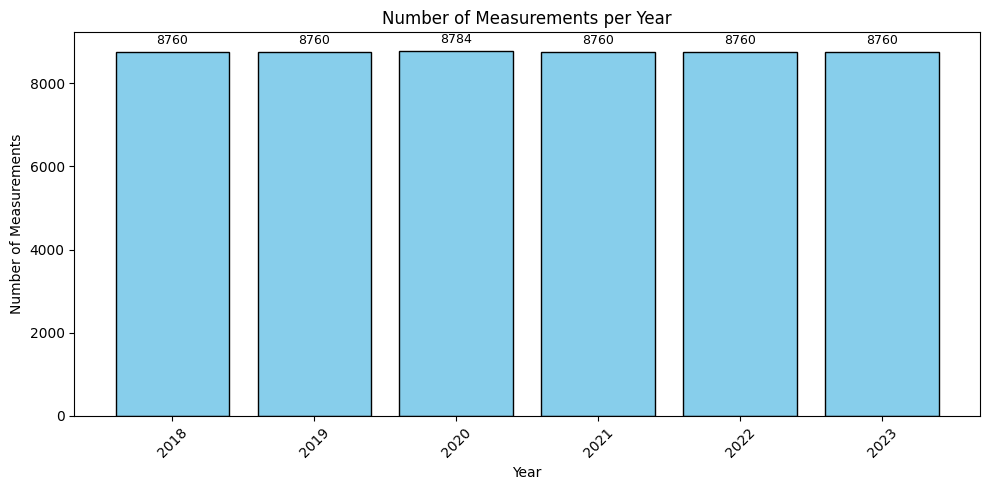

In [14]:
df_tmp = pd.DataFrame()
df_tmp['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

# Extract the year
df_tmp['year'] = df_tmp['time'].dt.year

# Count the number of measurements per year
count_per_year = df_tmp['year'].value_counts().sort_index()

# Plot the count per year
plt.figure(figsize=(10, 5))
bars = plt.bar(count_per_year.index.astype(str), count_per_year.values, color='skyblue', edgecolor='black')

# Add labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, str(int(height)), ha='center', va='bottom', fontsize=9)

plt.title("Number of Measurements per Year")
plt.xlabel("Year")
plt.ylabel("Number of Measurements")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
df.head(5)

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,P
0,20180101:0010,0.0,0.0,0.0,0.0,8.65,2.41,0.0
1,20180101:0110,0.0,0.0,0.0,0.0,8.64,2.48,0.0
2,20180101:0210,0.0,0.0,0.0,0.0,9.20,2.83,0.0
3,20180101:0310,0.0,0.0,0.0,0.0,9.58,3.10,0.0
4,20180101:0410,0.0,0.0,0.0,0.0,9.80,2.90,0.0


In [16]:
df.tail(5)

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,P
52579,20231231:1910,0.0,0.0,0.0,0.0,13.30,3.79,0.0
52580,20231231:2010,0.0,0.0,0.0,0.0,13.33,3.45,0.0
52581,20231231:2110,0.0,0.0,0.0,0.0,12.95,3.66,0.0
52582,20231231:2210,0.0,0.0,0.0,0.0,13.00,4.48,0.0
52583,20231231:2310,0.0,0.0,0.0,0.0,13.04,5.10,0.0


In [17]:
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
df = df.set_index('time').sort_index()

new_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15min')
df_15 = df.reindex(new_idx)

mask_zero_neighbor = (
    df_15["P"].eq(0) |
    df_15["P"].shift(-1).eq(0) |
    df_15["P"].shift(-2).eq(0) |
    df_15["P"].shift(1).eq(0) |
    df_15["P"].shift(2).eq(0)
)

df_15.loc[mask_zero_neighbor & df_15["P"].isna(), "P"] = 0

df_15 = df_15.interpolate(method="linear", limit_direction="both")

df_15 = df_15.reset_index().rename(columns={'index': 'time'})


df_15 = df_15.round({
    'Gb(i)': 4,
    'Gd(i)': 4,
    'Gr(i)': 4,
    'H_sun': 4,
    'T2m': 4,
    'WS10m': 4,
    'P': 4
})

df_15.head(10)


,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,P
0,2018-01-01 00:10:00,0.0,0.0,0.0,0.0,8.6500,2.4100,0.0
1,2018-01-01 00:25:00,0.0,0.0,0.0,0.0,8.6475,2.4275,0.0
2,2018-01-01 00:40:00,0.0,0.0,0.0,0.0,8.6450,2.4450,0.0
3,2018-01-01 00:55:00,0.0,0.0,0.0,0.0,8.6425,2.4625,0.0
4,2018-01-01 01:10:00,0.0,0.0,0.0,0.0,8.6400,2.4800,0.0
5,2018-01-01 01:25:00,0.0,0.0,0.0,0.0,8.7800,2.5675,0.0
6,2018-01-01 01:40:00,0.0,0.0,0.0,0.0,8.9200,2.6550,0.0
7,2018-01-01 01:55:00,0.0,0.0,0.0,0.0,9.0600,2.7425,0.0
8,2018-01-01 02:10:00,0.0,0.0,0.0,0.0,9.2000,2.8300,0.0
9,2018-01-01 02:25:00,0.0,0.0,0.0,0.0,9.2950,2.8975,0.0


In [18]:
df.reset_index(drop=True, inplace=True)
df_15["time"] = pd.to_datetime(df_15["time"])

# Train/test split
train = df_15[df_15["time"] < "2023-01-01"]
test = df_15[df_15["time"] >= "2023-01-01"]

# Save to CSV
train.to_csv("dataset/train_radiation_data.csv", index=False, float_format="%.4f")
test.to_csv("dataset/test_radiation_data.csv", index=False, float_format="%.4f")


In [19]:
realPV = test[["time", "P"]].copy()

realPV["time"] = pd.to_datetime(realPV["time"], format="%Y%m%d:%H%M")
realPV = realPV.set_index("time").sort_index()

# INTERPOLATION EVERY 3 MINUTES
new_idx_3min = pd.date_range(start=realPV.index.min(), end=realPV.index.max(), freq="3min")
df_3min = realPV.reindex(new_idx_3min)

# Mask: check 3 neighbors before and after for zeros
mask_zero_neighbor = (
    df_3min["P"].eq(0) |
    df_3min["P"].shift(-1).eq(0) | df_3min["P"].shift(-2).eq(0) | df_3min["P"].shift(-3).eq(0) |
    df_3min["P"].shift(1).eq(0) | df_3min["P"].shift(2).eq(0) | df_3min["P"].shift(3).eq(0)
)

df_3min.loc[mask_zero_neighbor & df_3min["P"].isna(), "P"] = 0

# Linear interpolation
df_3min = df_3min.interpolate(method="linear", limit_direction="both")

# Reset index
df_3min = df_3min.reset_index().rename(columns={"index": "time"})



# INTERPOLATION EVERY 5 SECONDS
df_3min = df_3min.set_index("time").sort_index()

new_idx_5s = pd.date_range(start=df_3min.index.min(), end=df_3min.index.max(), freq="5s")
df_5s = df_3min.reindex(new_idx_5s)

# Linear interpolation
df_5s = df_5s.interpolate(method="linear", limit_direction="both")

# Reset index
df_5s = df_5s.reset_index().rename(columns={"index": "time"})

df_3min["P"] = df_3min["P"].round(4)
df_5s["P"] = df_5s["P"].round(4)


In [20]:
# Save to CSV
df_5s.to_csv("dataset/real-powerPV.csv", index=False, float_format="%.4f")